In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

masked_cmap = matplotlib.cm.bwr
masked_cmap.set_bad('black', 0.5)

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("darkgrid")

# import models in ../scripts
import sys
sys.path.append("../scripts/")
from models import RandomFourierFeatureNetwork
from datasets import OOIDASDataset

## load data

In [136]:
TRAIN_DATA = mpimg.imread('./haystack-snow-effect.jpg')[:, :].astype('float')
TRAIN_DATA /= 256

([], [])

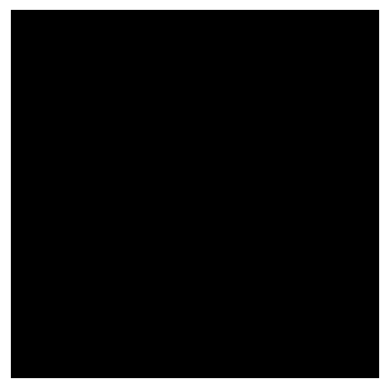

In [137]:
d = np.concatenate([np.zeros([30, 30, 2]), np.expand_dims(TRAIN_DATA[260:290, 130:160, 0], axis = -1), ], 
                   axis = -1).astype('uint8')
plt.imshow(d)
plt.grid(False)
plt.xticks([])
plt.yticks([])

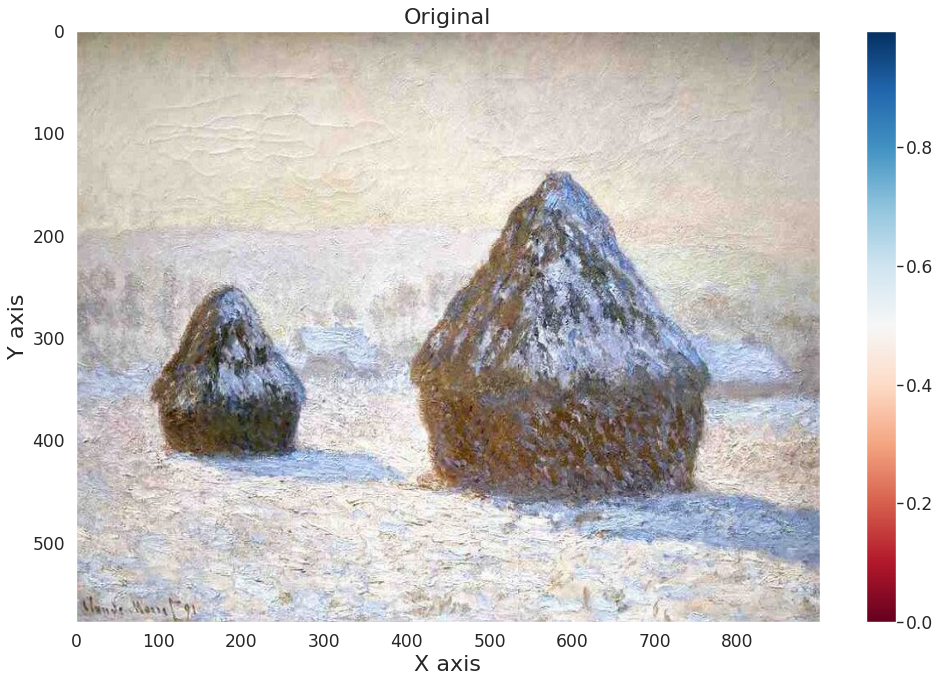

In [138]:
fig = plt.figure(figsize = (15, 9.6), dpi = 80)
plt.imshow(TRAIN_DATA[:, :], cmap = 'RdBu', aspect = 'auto', origin='upper')
plt.title("Original", fontsize = 20)
plt.ylabel("Y axis", fontsize = 20)
plt.xlabel("X axis", fontsize = 20)
plt.colorbar()
plt.grid(False)

## preprocessing data and send to data loader

In [186]:
NX, NT, NC = TRAIN_DATA.shape
t, x, c = np.meshgrid(np.arange(NT), np.arange(NX), np.arange(NC))
T = t/(NT-1); X = x/(NX-1); C = c/(NC-1);

n_feature = 196
B = np.random.normal(scale = 10, size = (n_feature, 3))

# nfeature = 2
# B = np.eye(2)

Bv = np.concatenate([T.reshape([-1, 1]), X.reshape([-1, 1]), C.reshape([-1, 1])], axis = -1)@B.T
all_data = np.concatenate([np.cos(2*np.pi*Bv), np.sin(2*np.pi*Bv), TRAIN_DATA.reshape([-1, 1])], axis = -1)

print(T.shape, X.shape, all_data.shape)

dataset = OOIDASDataset(all_data[:, :-1], np.expand_dims(all_data[:, -1], axis = -1))
data_loader = DataLoader(dataset, batch_size=4096, shuffle=True, num_workers=10)

(578, 900, 3) (578, 900, 3) (1560600, 393)


## defind model and initize the weights

In [187]:
device = torch.device('cuda')
model = RandomFourierFeatureNetwork(n_feature, n_layers=4)
for i in model.modules():
    if isinstance(i, torch.nn.Linear):
        i.weight.data.normal_(mean=0.0, std=0.1)
        i.bias.data.normal_(mean=0.0, std=0.1)

model.to(device);

In [188]:
n_weights = 0
for i in model.parameters():
    n_weights += len(i.data.flatten())
print(f"have total {n_weights}")

have total 231673


## training

In [189]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)
loss_fn = MSELoss()

In [190]:
nepoch = 5
train_losses = []
for t in range(nepoch):
    print(f"Epoch {t+1}")
    ## train
    model.train()
    train_loss = 0
    
    for batch_id, batch in tqdm(enumerate(data_loader), total = len(data_loader)):
        pred = model(batch[0].to(device))
        loss = loss_fn(pred, batch[1].to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(data_loader)
    train_losses.append(train_loss)
    print("train loss %.6f"  % (train_loss))

Epoch 1


100%|██████████| 382/382 [00:03<00:00, 106.38it/s]

train loss 0.013482
Epoch 2



100%|██████████| 382/382 [00:04<00:00, 86.82it/s] 

train loss 0.004287
Epoch 3



100%|██████████| 382/382 [00:06<00:00, 56.08it/s]

train loss 0.003752
Epoch 4



100%|██████████| 382/382 [00:05<00:00, 70.68it/s] 

train loss 0.003473
Epoch 5



100%|██████████| 382/382 [00:04<00:00, 87.84it/s] 

train loss 0.003373


Text(0, 0.5, 'Training loss')

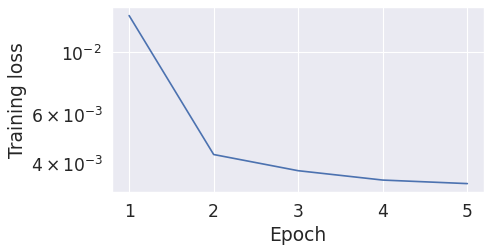

In [191]:
plt.figure(figsize = (6, 3), dpi = 80)
plt.plot(np.arange(1, 5 + 1), train_losses)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Training loss")

In [192]:
all_data_2d = all_data.reshape(NX, NT, NC, n_feature*2+1)[:, :, :n_feature*2]
predict = np.zeros([NX, NT, NC])

In [193]:
_gpu_predict = model(torch.Tensor(all_data_2d[:, :, :, :-1].reshape(-1, n_feature*2)).to(device)).reshape(NX, NT, 3)
predict = _gpu_predict.detach().cpu().numpy()
torch.cuda.empty_cache()

([], [])

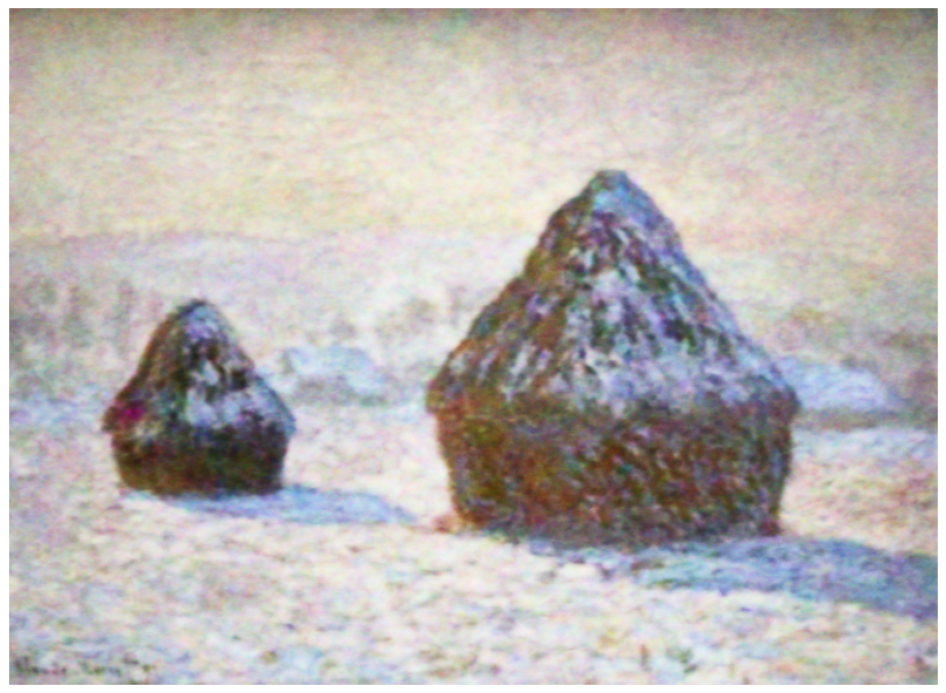

In [194]:
fig = plt.figure(figsize = (15, 11), dpi = 80)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='upper')
# plt.title("reconstructed", fontsize = 20)
# plt.ylabel("Y axis", fontsize = 20)
# plt.xlabel("X axis", fontsize = 20)
# plt.colorbar()
plt.grid(False)
plt.xticks([])
plt.yticks([])

([], [])

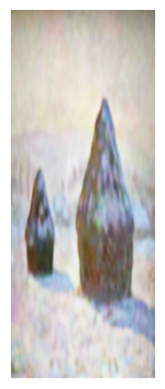

In [147]:
# plt.figure(figsize = (20, 6))
# plt.subplot(1,3,1)
# plt.imshow(TRAIN_DATA, cmap = 'RdBu', aspect = 'auto', origin='upper', 
#            vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
# plt.xticks([]); plt.yticks([])
# # plt.title("original", fontsize = 20)

plt.subplot(1,3,2)
plt.imshow(predict, cmap = 'RdBu', aspect = 'auto', origin='upper', 
           vmin = TRAIN_DATA.min(), vmax = TRAIN_DATA.max())
plt.xticks([]); plt.yticks([])
# plt.title("reconstruction", fontsize = 20)

# plt.subplot(1,3,3)
# plt.imshow(TRAIN_DATA - predict, cmap = 'RdBu', aspect = 'auto', origin='upper', vmin = -0.2, vmax = 0.2)
# plt.xticks([]); plt.yticks([])
# plt.colorbar()